In [8]:
%matplotlib inline

#Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import gmaps
from scipy.stats import linregress
from citipy import citipy
import seaborn as sns
import shapefile as shp

In [9]:
# Files to Load (Remember to Change These)
full_dataset = "Datasets/UK-HPI-full-file-2021-09.csv"
country_codes = "Datasets/Country_Codes.csv"
county_codes = "Datasets/County_Codes.csv"
counties_WM_codes = "Datasets/Counties_West_Mid.csv"
LAD_WM_County = "Datasets/LAD's_W_M_County.csv"
LAD_WM_Region = "Datasets/LAD's_W_M_Region.csv"
UK_Regions = "Datasets/Regions_Codes.csv"

# Read Files and store into Pandas data frame
full_data_ds = pd.read_csv(full_dataset)
country_df = pd.read_csv(country_codes )
county_df = pd.read_csv(county_codes)
counties_WM_df = pd.read_csv(counties_WM_codes)
LAD_WM_County_df = pd.read_csv(LAD_WM_County)
LAD_WM_Region_df = pd.read_csv(LAD_WM_Region)
UK_Regions_df = pd.read_csv(UK_Regions)

In [10]:
#convert Date column from Object to Date
full_data_ds['Date'] = pd.to_datetime(full_data_ds['Date'], format='%d/%m/%Y')

#filter data to keep only records after 01.01.2005
full_data_df = full_data_ds.loc[(full_data_ds['Date'] >= '2005-01-01')&(full_data_ds['Date'] <= '2021-06-01')]

full_data_df.reset_index()

index       Date                RegionName   AreaCode  AveragePrice  \
0          12 2005-01-01             Aberdeenshire  S12000034  101818.93310   
1          13 2005-02-01             Aberdeenshire  S12000034   97626.00076   
2          14 2005-03-01             Aberdeenshire  S12000034   94779.34241   
3          15 2005-04-01             Aberdeenshire  S12000034   95847.70590   
4          16 2005-05-01             Aberdeenshire  S12000034  101744.46620   
...       ...        ...                       ...        ...           ...   
83353  133558 2021-02-01  Yorkshire and The Humber  E12000003  181496.14780   
83354  133559 2021-03-01  Yorkshire and The Humber  E12000003  183307.83840   
83355  133560 2021-04-01  Yorkshire and The Humber  E12000003  179601.86860   
83356  133561 2021-05-01  Yorkshire and The Humber  E12000003  182339.40770   
83357  133562 2021-06-01  Yorkshire and The Humber  E12000003  193209.60250   

            Index     IndexSA  1m%Change  12m%Change  AveragePriceSA  ...  \
0       50.931127         NaN   1.311254   24.635034             NaN  ...   
1       48.833768         NaN  -4.118028   19.524339             NaN  ...   
2       47.409834         NaN  -2.915881   13.474088             NaN  ...   
3       47.944243         NaN   1.127211   13.652940             NaN  ...   
4       50.893877         NaN   6.152218   17.787127             NaN  ...   
...           ...         ...        ...         ...             ...  ...   
83353  133.287710  131.966380   0.676243   10.430615     179696.9107  ...   
83354  134.618185  132.481043   0.998198   10.853888     180397.7204  ...   
83355  131.896583  130.910116  -2.021719   12.152713     178258.6093  ...   
83356  133.906985  132.158707   1.524226   10.528659     179958.7996  ...   
83357  141.889873  139.804564   5.961517   15.046007     190370.0638  ...   

          NewPrice    NewIndex  New1m%Change  New12m%Change  NewSalesVolume  \
0      110316.4351   50.229911      2.324090      24.741351            42.0   
1      106585.6577   48.531192     -3.381887      20.291087            52.0   
2      103578.4143   47.161917     -2.821433      14.708698            91.0   
3      104801.7981   47.718955      1.181118      16.034034            81.0   
4      111125.9358   50.598498      6.034379      20.803271            82.0   
...            ...         ...           ...            ...             ...   
83353  227457.5470  136.975684      2.267499      11.056185           137.0   
83354  231530.8462  139.428638      1.790795      10.042456           189.0   
83355  238319.9314  143.517048      2.932260      13.736591            82.0   
83356  237438.5391  142.986271     -0.369836      10.255076            59.0   
83357  247646.4622  149.133515      4.299185      19.493385            63.0   

           OldPrice    OldIndex  Old1m%Change  Old12m%Change  OldSalesVolume  
0      100978.67930   50.939624      0.934250      24.597429           358.0  
1       96558.90015   48.710026     -4.376943      19.259616           237.0  
2       93662.15635   47.248737     -2.999976      12.977680           344.0  
3       94708.33337   47.776490      1.116969      12.742658           418.0  
4      100556.18030   50.726490      6.174585      16.623743           433.0  
...             ...         ...           ...            ...             ...  
83353  178895.40880  133.269736      0.513515      10.391553          6927.0  
83354  180535.50600  134.491542      0.916791      11.016028          8909.0  
83355  175987.86980  131.103739     -2.518971      12.140930          6375.0  
83356  179017.74980  133.360876      1.721641      10.699447          5352.0  
83357  189999.57850  141.541887      6.134492      14.597427          5402.0  

[83358 rows x 55 columns]

The highest sales volume in England
           Date RegionName  SalesVolume
2407 2007-08-01    England     121246.0
The lowest sales volume in England
           Date RegionName  SalesVolume
2559 2020-04-01    England      23673.0
The highest sales volume in West Midlands Region
           Date            RegionName  SalesVolume
1409 2006-12-01  West Midlands Region      11472.0
The lowest sales volume in West Midlands Region
           Date            RegionName  SalesVolume
1569 2020-04-01  West Midlands Region       2290.0


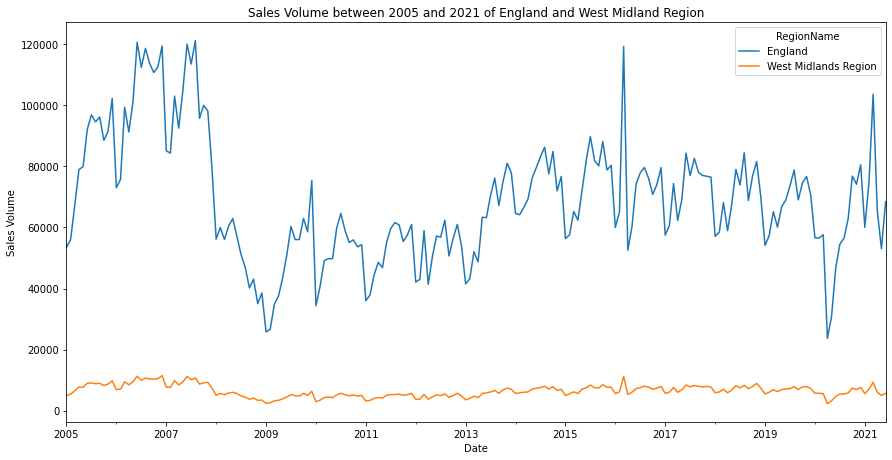

In [11]:
# merge datasets to keep only regions records

merge_regions_df = pd.merge(UK_Regions_df,full_data_df)

#create a new dataframe to contains only the County Name and Average Detached House prices
s_regions_df = merge_regions_df[['Date','RegionName','SalesVolume']]
#create a list for filtering
filter_list2 = ['England', 'West Midlands Region']
#filter the data frame fro England and West Midlands
swm_regions_df = s_regions_df[s_regions_df.RegionName.isin(filter_list2)]
#delete rows for the last 2 months as no sale volumes are provided
swm_regions_df1 = swm_regions_df.dropna(axis=0)

#calculate and print max and min per region
eng_df = swm_regions_df1[swm_regions_df1.RegionName == 'England']
swm_df = swm_regions_df1[swm_regions_df1.RegionName == 'West Midlands Region']
print('The highest sales volume in England')
print(eng_df[eng_df['SalesVolume'] == eng_df.SalesVolume.max()])
print('The lowest sales volume in England')
print(eng_df[eng_df['SalesVolume'] == eng_df.SalesVolume.min()])
print('The highest sales volume in West Midlands Region')
print(swm_df[swm_df['SalesVolume'] == swm_df.SalesVolume.max()])
print('The lowest sales volume in West Midlands Region')
print(swm_df[swm_df['SalesVolume'] == swm_df.SalesVolume.min()])

swm_eng_max_min = swm_regions_df1.set_index('Date')
swm_eng_max_min_grouped = swm_eng_max_min.groupby('RegionName')['SalesVolume'].agg('max')
swm_eng_max_min_grouped

#set up the graph size
plt.rcParams["figure.figsize"] = [12.50, 6.50]
plt.rcParams["figure.autolayout"] = True
#create the graph and add the title and Y axis name
swm_regions_df1 = swm_regions_df1.pivot(index='Date', columns='RegionName', values='SalesVolume')
swm_regions_df1.plot(title = 'Sales Volume between 2005 and 2021 of England and West Midland Region')
plt.ylabel('Sales Volume')
#save the graph as PNG
plt.savefig("Images/Sales_England_vs_WMRegion.png")
plt.show()

The highest sales volume in West Midlands Region
         Date     RegionName  SalesVolume
29 2007-06-01  West Midlands       5163.0
The lowest sales volume in West Midlands Region
           Date          RegionName  SalesVolume
1434 2009-01-01  Telford and Wrekin         57.0


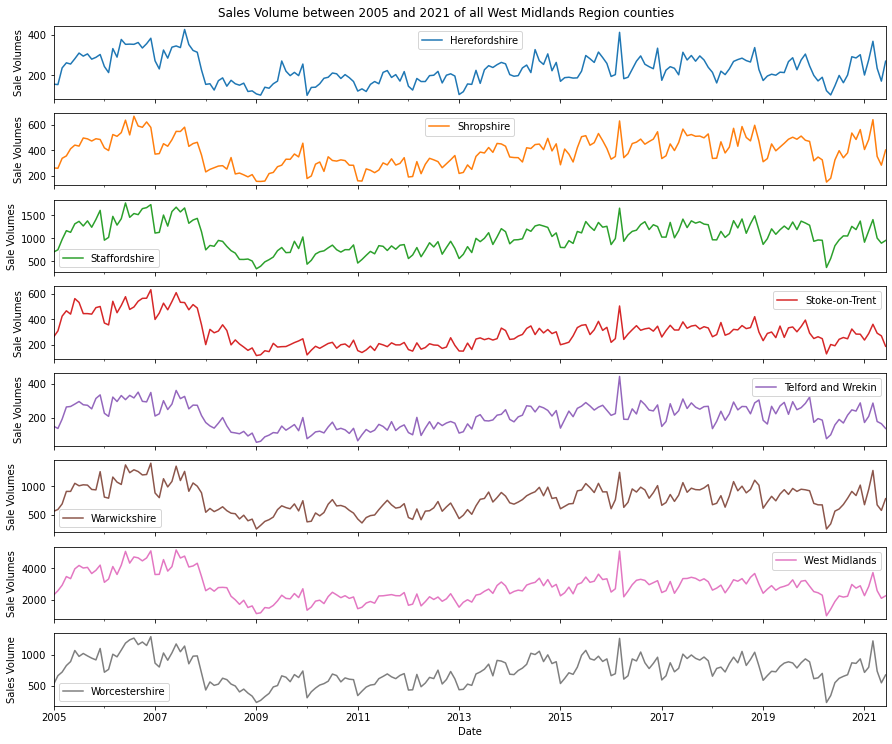

In [23]:
# merge datasets to keep only regions records

merge_regions_df1 = pd.merge(counties_WM_df,full_data_df)

#create a new dataframe to contains only the County Name and Average Detached House prices
c_regions_df = merge_regions_df1[['Date','RegionName','SalesVolume']]
#drop all records for England
swm_counties_df = c_regions_df[c_regions_df.RegionName != 'England']
#delete rows with no values provided
swm_counties_df1 = swm_counties_df.dropna(axis=0)

print('The highest sales volume in West Midlands Region')
print(swm_counties_df[swm_counties_df['SalesVolume'] == swm_counties_df.SalesVolume.max()])
print('The lowest sales volume in West Midlands Region')
print(swm_counties_df[swm_counties_df['SalesVolume'] == swm_counties_df.SalesVolume.min()])

#set up the graph size
plt.rcParams["figure.figsize"] = [12.50, 10.50]
plt.rcParams["figure.autolayout"] = True
#create the graph and add the title and Y axis name
swm_counties_df1 = swm_counties_df1.pivot(index='Date', columns='RegionName', values='SalesVolume')
swm_counties_df1.plot(subplots=True, title = 'Sales Volume between 2005 and 2021 of all West Midlands Region counties', ylabel = 'Sale Volumes')
plt.ylabel('Sales Volume')
#save the graph as PNG
plt.savefig("Images/Sales_WM_Region.png")
plt.show()

In [18]:
import plotly.express as px
swm_counties_df1
fig1 = px.bar(swm_counties_df1,
              x='RegionName',
              y='SalesVolume',
              color='RegionName',
              animation_frame='Date',
              range_y=[0,6000]
             )
fig1.update_layout(height=600, title_text='Sales Volume between 2005 and 2021 of all West Midlands Region counties')
fig1.show()

In [19]:
#saving the animation
fig1.write_html("Images/animation.html")

In [59]:
#calculate max of each group
swm_max = swm_counties_df.groupby(['RegionName'])['SalesVolume'].transform(max) == swm_counties_df['SalesVolume']
print('The highest sales volume in West Midlands Region by county')
swm_counties_df[swm_max]

The highest sales volume in West Midlands Region by county


Date          RegionName  SalesVolume
29   2007-06-01       West Midlands       5163.0
221  2006-12-01      Worcestershire       1289.0
413  2006-06-01       Staffordshire       1770.0
625  2007-08-01       Herefordshire        426.0
815  2006-12-01        Warwickshire       1403.0
1009 2006-08-01          Shropshire        667.0
1211 2006-12-01      Stoke-on-Trent        633.0
1520 2016-03-01  Telford and Wrekin        443.0

In [61]:
#calculate min of each group
swm_min = swm_counties_df.groupby(['RegionName'])['SalesVolume'].transform(min) == swm_counties_df['SalesVolume']
print('The highest sales volume in West Midlands Region by county')
swm_counties_df[swm_min]

The highest sales volume in West Midlands Region by county


Date          RegionName  SalesVolume
183  2020-04-01       West Midlands        963.0
381  2020-04-01      Worcestershire        232.0
444  2009-01-01       Staffordshire        330.0
654  2010-01-01       Herefordshire        102.0
840  2009-01-01        Warwickshire        255.0
1173 2020-04-01          Shropshire        149.0
1236 2009-01-01      Stoke-on-Trent        115.0
1434 2009-01-01  Telford and Wrekin         57.0

The highest sales volume in West Midlands County
          Date  RegionName  SalesVolume
134 2016-03-01  Birmingham       1978.0
The lowest sales volume in West Midlands County
           Date     RegionName  SalesVolume
1248 2010-01-01  Wolverhampton         78.0


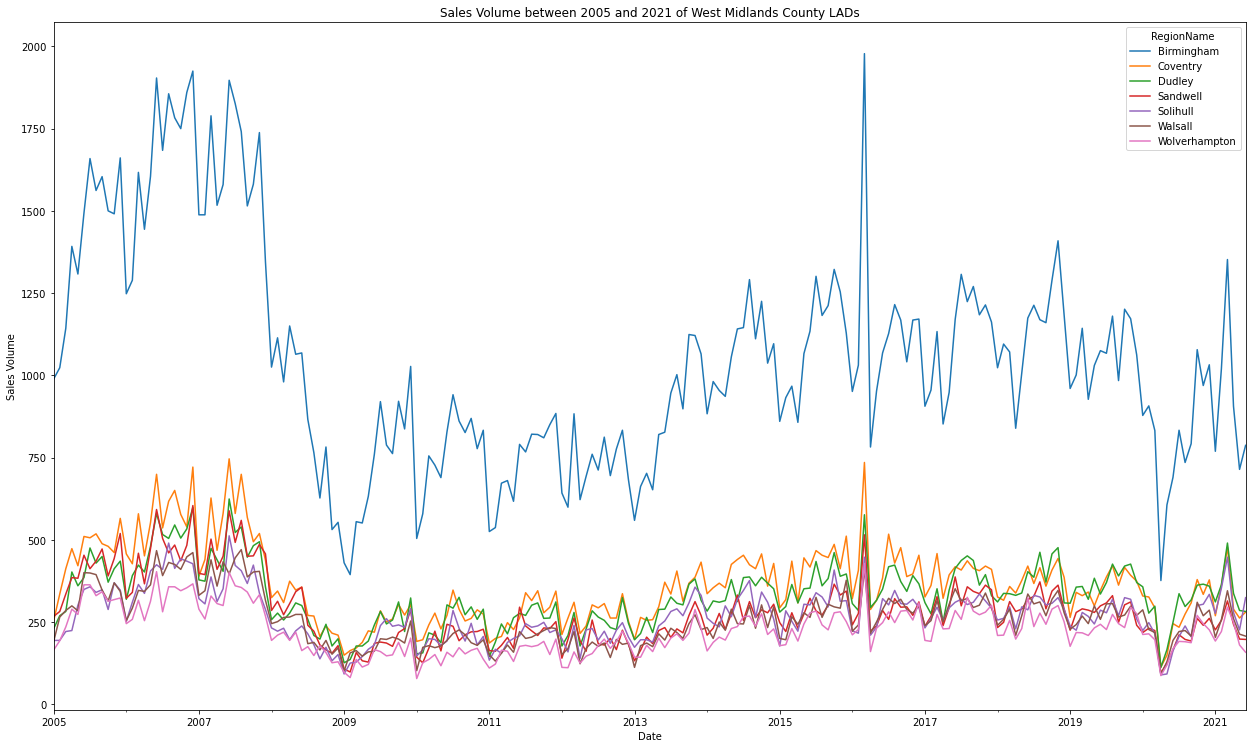

In [41]:
# merge datasets to keep only LAD records
merge_LAD_df = pd.merge(LAD_WM_County_df,full_data_df)
#create a new dataframe to contains only the County Name and Average Detached House prices
s_LAD_df = merge_LAD_df[['Date','RegionName','SalesVolume']]
#drop all records fpr England
swm_LAD_df = s_LAD_df[s_LAD_df.RegionName != 'England']
#delete rows for the last 2 months as no sale volumes are provided
swm_LAD_df1 = swm_LAD_df.dropna(axis=0)

print('The highest sales volume in West Midlands County')
print(swm_LAD_df[swm_LAD_df['SalesVolume'] == swm_LAD_df.SalesVolume.max()])
print('The lowest sales volume in West Midlands County')
print(swm_LAD_df[swm_LAD_df['SalesVolume'] == swm_LAD_df.SalesVolume.min()])

#set up the graph size
plt.rcParams["figure.figsize"] = [17.50, 10.50]
plt.rcParams["figure.autolayout"] = True
#create the graph and add the title and Y axis name
swm_LAD_df1 = swm_LAD_df1.pivot(index='Date', columns='RegionName', values='SalesVolume')
swm_LAD_df1.plot(title = 'Sales Volume between 2005 and 2021 of West Midlands County LADs')
plt.ylabel('Sales Volume')
#save the graph as PNG
plt.savefig("Images/Sales_LAD_WMRegion.png")
plt.show()



In [55]:
#calculate max of each group
idx = swm_LAD_df.groupby(['RegionName'])['SalesVolume'].transform(max) == swm_LAD_df['SalesVolume']
print('The highest sales volume in West Midlands County by LAD')
swm_LAD_df[idx]

The highest sales volume in West Midlands County


Date     RegionName  SalesVolume
134  2016-03-01     Birmingham       1978.0
227  2007-06-01       Coventry        746.0
425  2007-06-01         Dudley        624.0
617  2006-12-01       Sandwell        604.0
821  2007-06-01       Solihull        512.0
1021 2007-08-01        Walsall        470.0
1322 2016-03-01  Wolverhampton        428.0

In [56]:
#calculate min of each group
idx2 = swm_LAD_df.groupby(['RegionName'])['SalesVolume'].transform(min) == swm_LAD_df['SalesVolume']
print('The lowest sales volume in West Midlands County by LAD')
swm_LAD_df[idx2]

The lowest sales volume in West Midlands County


Date     RegionName  SalesVolume
183  2020-04-01     Birmingham        376.0
381  2020-04-01       Coventry        113.0
579  2020-04-01         Dudley        112.0
777  2020-04-01       Sandwell         95.0
975  2020-04-01       Solihull         89.0
1173 2020-04-01        Walsall         91.0
1248 2010-01-01  Wolverhampton         78.0